https://catalog.data.gov/dataset/baby-names-from-social-security-card-applications-national-level-data

In [240]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob
from scipy.stats import entropy

In [241]:
files = glob('us-data/*.txt')
years = range(1880, 2019)
df = pd.DataFrame()
for y in years:
    df_ = pd.read_csv('us-data/yob{}.txt'.format(y), header=None,  names=['Name', 'Sex', 'Count'])
    df_['Year'] = y
    df = pd.concat((df, df_))

In [242]:
df.head()

,Name,Sex,Count,Year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880


In [243]:
df['Frequency'] = df.groupby('Year')['Count'].transform(lambda x: x / x.sum())
df['Sex-Frequency'] = df.groupby(['Year','Sex'])['Count'].transform(lambda x: x / x.sum())

df[df['Name']=='John'].head()

,Name,Sex,Count,Year,Frequency,Sex-Frequency
228,John,F,46,1880,0.000228,0.000506
942,John,M,9655,1880,0.047919,0.087383
312,John,F,26,1881,0.000135,0.000283
938,John,M,8769,1881,0.045507,0.087043
277,John,F,40,1882,0.000181,0.000371


In [244]:
def diversity(x):
    return np.exp(entropy(x))

def richness(x):
    x = np.array(x)
    return (x>0).sum()

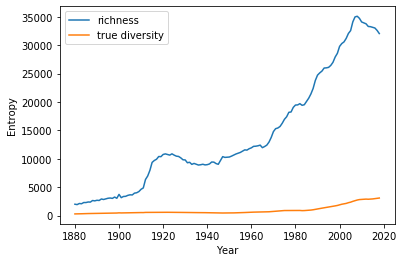

In [245]:
df.groupby('Year')['Frequency'].aggregate(richness).plot.line(label='richness')
df.groupby('Year')['Frequency'].aggregate(diversity).plot.line(label='true diversity')
plt.ylabel('Entropy')
plt.legend();

In [246]:
def plot_name(name, sex, logscale=False, ax=None):
    if ax is None: fig, ax = plt.subplots()
    idx = (df['Name'] == name) & (df['Sex'] == sex)
    year = df.loc[idx, 'Year']
    freq = df.loc[idx, 'Frequency']
    ax.plot(year, freq, label="{} ({})".format(name, sex))
    if logscale: ax.set_yscale('log')
    return ax

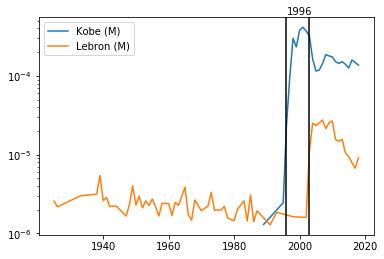

In [247]:
ax = plot_name('Kobe', 'M', logscale=True)
plot_name('Lebron', 'M', logscale=True, ax=ax)
plt.axvline(1996, color='k')
plt.axvline(2003, color='k')
plt.text(1996, 6e-4, '1996')
plt.legend();

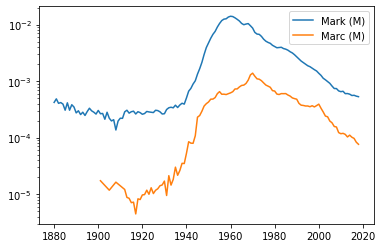

In [248]:
ax = plot_name('Mark', 'M', logscale=True)
plot_name('Marc', 'M', logscale=True, ax=ax)
plt.legend();

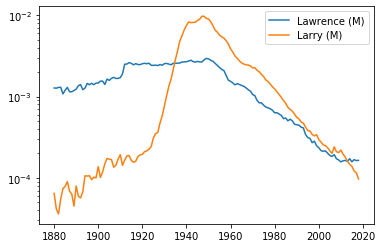

In [249]:
ax = plot_name('Lawrence', 'M', logscale=True)
plot_name('Larry', 'M', logscale=True, ax=ax)
plt.legend();

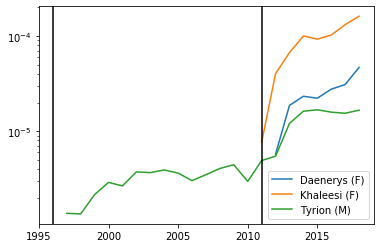

In [250]:
ax = plot_name('Daenerys', 'F', logscale=True)
plot_name('Khaleesi', 'F', logscale=True, ax=ax)
plot_name('Tyrion', 'M', logscale=True, ax=ax)
plt.axvline(1996, color='k')
plt.axvline(2011, color='k')
plt.xlim(1995, None)
plt.legend();

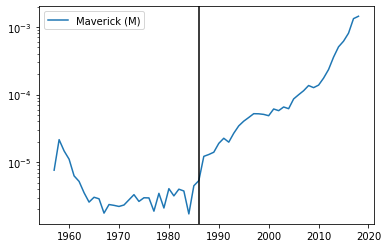

In [251]:
ax = plot_name('Maverick', 'M', logscale=True)
plt.axvline(1986, color='k')
plt.legend();

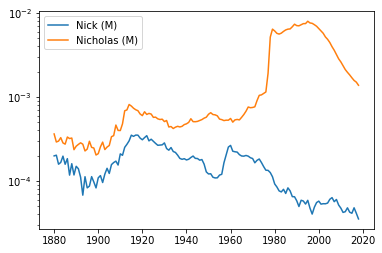

In [252]:
ax = plot_name('Nick', 'M', logscale=True)
plot_name('Nicholas', 'M', logscale=True, ax=ax)
plt.legend();

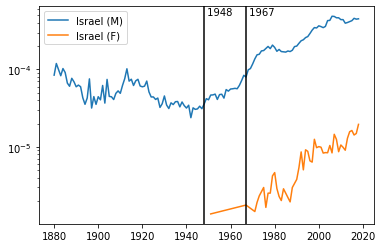

In [253]:
ax = plot_name('Israel', 'M', logscale=True)
plot_name('Israel', 'F', ax=ax, logscale=True)
plt.axvline(1948, color='k')
plt.text(1948, 5e-4, ' 1948')
plt.axvline(1967, color='k')
plt.text(1967, 5e-4, ' 1967')
plt.legend();

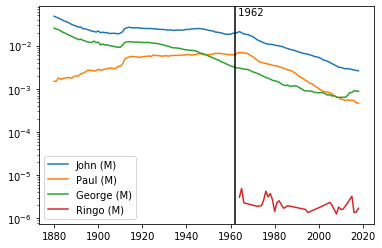

In [254]:
ax = plot_name('John', 'M', logscale=True)
plot_name('Paul', 'M', logscale=True, ax=ax)
plot_name('George', 'M', logscale=True, ax=ax)
plot_name('Ringo', 'M', logscale=True, ax=ax)
ax.axvline(1962, color='k')
plt.text(1962, 5e-2, ' 1962')
plt.legend();

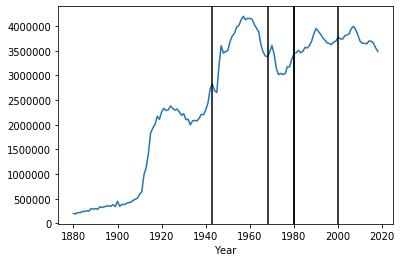

In [255]:
df.groupby('Year')['Count'].sum().plot()
plt.axvline(1943, color='k')
plt.axvline(1968, color='k')
plt.axvline(1980, color='k')
plt.axvline(1980, color='k')
plt.axvline(2000, color='k');

In [256]:
common_names = df.groupby(['Name', 'Sex'])['Frequency'].aggregate(lambda x: (x>1e-5).all()).reset_index()

In [257]:
common_names = common_names[common_names['Frequency'] == True]

In [258]:
idx = np.random.choice(common_names.index, 10, replace=False)
df_ = pd.merge(common_names.loc[idx, ['Name', 'Sex']], df, on=('Name', 'Sex'))
grp_name_sex = df_.groupby(['Name', 'Sex'])

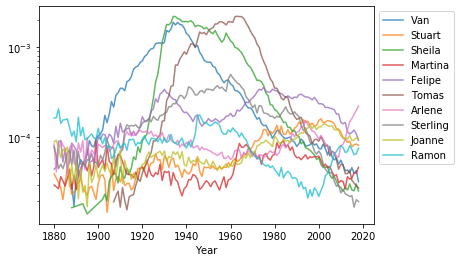

In [259]:
fig, ax = plt.subplots()
grp_name_sex.plot.line('Year', 'Frequency', ax=ax, alpha=0.75)
ax.set_yscale('log')
ax.legend(df_['Name'].unique(), bbox_to_anchor=(1, 1));

## Single Name Model

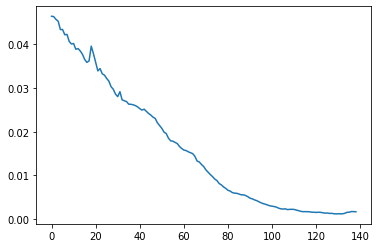

In [260]:
single_name_df = df[(df['Name'] == 'George')&(df['Sex'] == 'M')]
P = single_name_df['Sex-Frequency'].values
Y = single_name_df['Count'].values
N = df[df['Sex'] == 'M'].groupby('Year')['Count'].sum().values
t = np.arange(len(N))

assert len(N) == len(P)

plt.plot(t,P);


In [261]:
def plot_model(θ,t,p0,model):
    p_hat = model(θ,t,p0)
    
    plt.plot(t,p_hat)
    plt.xlabel('Time(y)')
    plt.ylabel('Frequency')

## Simple Selection Model

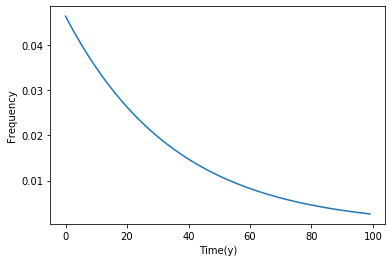

In [262]:
def simple_verify_params(θ):
    s = θ
    if s > -1:
        return True
    return False

def simple_step(s,p):
    w = 1 + s
    w_mean = w*p + (1-p)
    p_tag = w*p / w_mean
    return p_tag

def simple_model(θ,t,p0):
    p = np.zeros(len(t))
    p[0] = p0
    for i in t[1:]:
        p[i] = simple_step(θ,p[i-1])

    return p    
        
t = np.arange(100)
θ = (-0.029)
plot_model(θ,t,P[0],simple_model);

## Frequency Parabola-Dependant Model

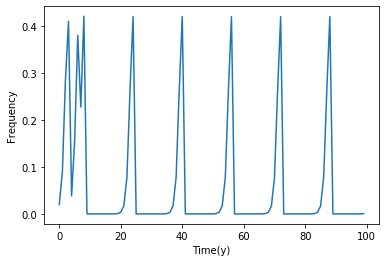

In [393]:
from ipywidgets import interact

def verify_freq_params(θ):
    return True
#     a,b,c = θ
#     if c <0 and a <0 and b>0 and b < -2*a and a<c and b**2 > 4*a*c and b < -(c + a):
#         return True
#     return False

def frequency_step(a,b,c,p):
    s = a*(p**2) + b*p + c
    s = s if s > -1 else -0.9999999999
    w = 1 + s
    w_mean = w*p + (1-p)
    p_tag = w*p / w_mean
    return p_tag

def frequency_model(θ,t,p0):
    a,b,c = θ
    p = np.zeros(len(t))
    p[0] = p0
    for i in t[1:]:
        p[i] = frequency_step(a,b,c,p[i-1])

    return p    
        
t = np.arange(100)
θ = (-5,-10,4)
plot_model(θ,t,0.02,frequency_model);
    
# interact(plot_interact,
#         n = (1,200,1), p0 = (0,1,0.001), a=(-5,0,0.01),b=(-10,20,0.5),c=(-20,30,2));

## Fitting to the data

In [394]:
import scipy

def rss(y,y_hat):
    return np.sum((y-y_hat)**2)

def log_likelihood(θ,Y,N,t,p0,model,verify_params): 
    n = θ[-1]
    if n <= 0 or n > 1:
        return -np.inf
    if not verify_params(θ[:-1]):
        return -np.inf
    P_hat = model(θ[:-1],t,p0)
    return scipy.stats.binom.logpmf(Y,n*N,P_hat).sum()

def neg_log_likelihood(θ,Y,N,t,p0,model,verify_params):
    loss = -log_likelihood(θ,Y,N,t,p0,model,verify_params)
    return loss


## Fitting validation

In [395]:
t = np.arange(len(P))
s = -0.029
simulated_P = simple_model(s,t,P[0])
simulated_Y = np.array(N*simulated_P,dtype=int)


θ0 = (-0.9,0.5)
args = (simulated_Y,N,t,P[0],simple_model,simple_verify_params)
θ_hat_simple = scipy.optimize.fmin(
        func=neg_log_likelihood, 
        x0=θ0,
        args=args,
        maxiter=10000,
)
s1,n1 = θ_hat_simple
print(f'\n\ns_hat = {s1:.3f}\tn_hat={n1:.3f}')
print(f's = {s:.3f}')

assert np.isclose(s,s1,rtol=10e-4)


Optimization terminated successfully.
         Current function value: 725.040364
         Iterations: 59
         Function evaluations: 115


s_hat = -0.029	n_hat=1.000
s = -0.029


In [532]:
def minimize_model(θ0,Y,N,t,P0,model,params_verification):
    args = (Y,N,t,P[0],model,params_verification)
    θ_hat = scipy.optimize.fmin(
            func=neg_log_likelihood, 
            x0=θ0,
            args=args,
            maxiter=2000,
    )
    return θ_hat

def get_data_arrays(name,sex):
    assert (sex == 'M') or (sex == 'F')
    single_name_df = df[(df['Name'] == name)&(df['Sex'] == sex)]
    years = single_name_df['Year'].values
    P = single_name_df['Sex-Frequency'].values
    Y = single_name_df['Count'].values
    N = df[(df['Sex'] == sex) & (df['Year'].isin(years))].groupby('Year')['Count'].sum().values
    t = np.arange(len(N))
    assert len(N) == len(P)
    
    return P,Y,N,t

def model_and_plot_by_name(name,sex):
    P,Y,N,t = get_data_arrays(name,sex)
    
    θ0 = (-0.0001,0.3)
    θ_hat_simple = minimize_model(θ0,Y,N,t,P[0],simple_model,simple_verify_params)
    s1,n1 = θ_hat_simple
    print(f'\n\ns = {s1:.4f}\tn = {n1:.4f}')
    
    θ0 = (0,0,-0.0001,0.3)
    θ_hat_freq = minimize_model(θ0,Y,N,t,P[0],frequency_model,verify_freq_params)
    a2,b2,c2,n2 = θ_hat_freq
    print(f'\n\na = {a2:.4f}\tb = {b2:.4f}\tc = {c2:.4f}\tn = {n2:.4f}')
    
    p_hat_simple = simple_model(s1,t,P[0])
    p_hat_freq = frequency_model((a2,b2,c2),t,P[0])

    plt.scatter(t,P,label='data',s=2,color='k')
    plt.plot(t,p_hat_simple,label='simple model',color='r')
    plt.plot(t,p_hat_freq,linestyle='-.',label='parabola model',color='g')
    plt.xlabel('Time(y)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.savefig(f'names_fitting_graphs/{name}_{sex}.pdf')
    plt.show();
    

Optimization terminated successfully.
         Current function value: 21700.690867
         Iterations: 57
         Function evaluations: 111


s = -0.0075	n = 0.8049
Optimization terminated successfully.
         Current function value: 21821.108153
         Iterations: 125
         Function evaluations: 222


a = -0.1526	b = 0.4287	c = -0.0078	n = 0.7853


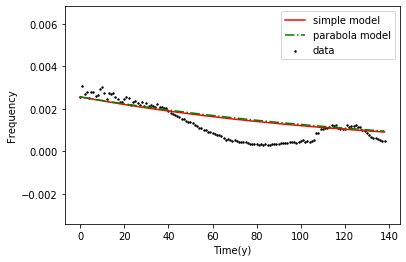

In [533]:
model_and_plot_by_name('Edgar','M')

## Searching for most noiseless names

In [523]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

lowess = sm.nonparametric.lowess

def get_sorted_names_by_noise(sex,topk=10,years_lim=139,freq_tol=0.0005):
    name_counts = df[df['Sex'] == sex]['Name'].value_counts()
    names = name_counts[name_counts>=years_lim].index
    freq_means = df[(df['Sex'] == sex) & (df['Name'].isin(names))].groupby('Name')['Sex-Frequency'].mean()
    names = freq_means[freq_means>freq_tol].index
    
    mses = []
    for name in names:
        P,Y,N,t = get_data_arrays(name,sex)
        smoothed_P = lowess(P,t)[:,1]
        mse = mean_squared_error(P,smoothed_P)
        mses.append(mse)
    
    mses = np.array(mses)
    indices = np.argpartition(mses, topk)[:topk]
    return names[indices]

top_M_names=get_sorted_names_by_noise('M',topk=25,years_lim=100,freq_tol=0.001)


In [524]:
top_M_names

Index(['Oscar', 'Edwin', 'Edgar', 'Eddie', 'Jessie', 'Martin', 'Harvey',
       'Allen', 'Alvin', 'Manuel', 'Herman', 'Ian', 'Curtis', 'Phillip',
       'Wesley', 'Ben', 'Clyde', 'Frederick', 'Claude', 'Lewis', 'Philip',
       'Victor', 'Leon', 'Lee', 'Joel'],
      dtype='object', name='Name')